# Demodulation of Sagnac

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
#import obspy as obs


from scipy.fft import fft
from scipy import optimize
from scipy.signal import butter, lfilter, resample, hilbert, ricker


### Setting crucial parameters

In [2]:
## dividing by
div = 10

## --------------------------------------------------------------------

## assumed sagnac frequency 
sgnc = 55

## sampling, time duration and points 
sps = 500
T   = 160
pts = sps * T

time = np.arange(0,T,1/sps)

#fg = 0.001

noise = np.random.rand(len(time))



### Defining several methods

In [3]:

def __create_event(T, sps, frequency, noise):
    
    '''
    creating a transient event signal by combining ricker wavelets, which is subsequently modulated onto the carrier signal
    
    T         = total time of trace
    sps       = samples per second corresponding to anlog signal
    frequency = dominant frequency of ricker wavelet
    noise     = True/False , to either include or exclude noise for the event signal
    '''
    
    ## shift the transient signal along the trace in time dimension
    offset = 3000
    

    spikes = np.array([1,5,4,8,15,17,70,72,75,79,85])*10 + offset
    ref = np.zeros(int(T*sps))
    rick = ricker(pts, frequency)

    for i in spikes:
        ref[i] = 1
        
    if noise:        
        noise = np.random.rand(T*sps)
        event = np.convolve(rick,ref,'same') + 0.03 * noise
    else:
        event = np.convolve(rick,ref,'same')


    event_fft = fft(event)
    #event_fft_db = 20*np.log10(event_fft/max(event_fft))

    ## _______________________________________________________________________________

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

    ff = np.linspace(0,0.5*sps,pts)
    N = len(ff)
    time = np.arange(0,T,1/sps)

    ax1.plot(time,event,color='black')
    ax2.plot(ff[:N // 2],np.abs(event_fft[:N // 2]))

    ax1.set_xlim(min(spikes)/sps-0.1*min(spikes)/sps,max(spikes)/sps+0.1*max(spikes)/sps)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Counts')
    
    ax2.set_xlim(0,200/frequency)
    ax2.set_ylim(0,max(np.abs(event_fft[10:N // 2]))+0.01*max(np.abs(event_fft[:N // 2])))
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Spectral Amplitude')
    
    plt.show();
    
    return time, event


In [4]:

def __analog_to_digital(sgnc,event,T,sps,fsd,factor):

    ''' resample the simulated analog signal to get a digital data stream '''


    sig_ana = np.sin(2*np.pi*(sgnc + factor * event ) * time ) 
    #sig_ana = np.sin(2*np.pi*(sgnc ) * time ) 


    ## --------------------------------------------------------------------

    #fsd = sps/2


    sp  = np.arange(0,T*sps,sps/fsd)
    spt = np.arange(0,T,1/fsd)


    sig_dig = []
    for i in sp:
        sig_dig.append(sig_ana[int(i)])

    sig_dig = np.array(sig_dig)

    return sig_dig

    ## _______________________________________________________________________________

    fig, ax = plt.subplots(1,1,figsize=(15,5))

    #ax.scatter(sp,sig,s=0.01)
    #ax.plot(time,sig_ana)

    ax.scatter(spt,sig_dig,s=15,color='black')
    ax.plot(spt,sig_dig,color='grey')

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Counts')
    ax.set_xlim(0,0.25)

    plt.show();
    

In [5]:

def __resample_digital_signal(sig_in,fs,fac,taper):

    ''' 
    
    up-samping of the simulated digital signal 
    
    sig_in   = input signal
    fs       = sampling frequency of digital signal
    fac      = sampling factor (2 = double)
    taper    = True/False , to either taper or not taper output
    
    '''
    

    def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a


    def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y


    def resampling(sig_in,fac,fs,select):

        if select == 1:
            sig_out = resample(sig_in,len(sig_in)*fac)

        elif select == 2:
            sig = list(sig_in); i=0

            while i < len(sig):
                sig.insert(i, 0.0)
                i += 2
            sig_out = np.array(sig)

        time_out = np.arange(0,len(sig_in)/fs,1/(fs*fac))

        return  (sig_out, time_out)



    #sig_dig_fil_res, tt_res = resampling(sig_dig_fil,2,fs,2)
    sig_dig_res, tt_res = resampling(sig_in,2,fs,1)


    sig_dig_res_tap = np.hanning(len(sig_dig_res)) * sig_dig_res
    #sig_dig_res_tap_fil = butter_bandpass_filter(sig_dig_res_tap,0.1,100,fs,4)


    ## _______________________________________________________________________________

    fig, ax = plt.subplots(1,1,figsize=(15,5))

    tt     = tt_res
    signal = sig_dig_res
    
    
    ax.plot(tt,signal,color='grey')

    ax.scatter(tt,signal,s=15,color='black')

    ax.scatter(tt[::2],signal[::2],s=15,color='red')
    #ax.plot(tt[1::2],signal[1::2],color='darkred')


    ax.set_xlim(0,0.25)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Counts')

    plt.show();
    
    ## _______________________________________________________________________________
   
    
    if taper:
        return tt_res, sig_dig_res_tap
    
    elif not taper:
        return tt_res, sig_dig_res
    

In [6]:

def __sinus_fit(input1, input2, step, over):

    ''' Fitting a sin-functionto the resampled data to estimate an instantaneous frequency '''
    
    def func(x, a, b):
        return a * np.sin(2*np.pi* b * x) * np.hanning(len(x))

    dt = (input1[2]-input1[1])

    amps=[]
    freq=[]

    ## create time refernce 
    tt = np.arange(step,len(input1)-step, over) 

    
    for idx in tt:

        idx = int(idx)
        
        ## start values for fit
        a0 = 0.9
        b0 = 54
        b1 = 55
        
        ## condition for fit
        while abs(b0-b1) > 0.1:
            b0 = b1
            params, params_covariance = optimize.curve_fit(func, input1[idx-step:idx+step], np.hanning(len(input2[idx-step:idx+step]))*input2[idx-step:idx+step],p0=[a0, b0])
            b1 = params[1]


        amps.append(params[0])
        freq.append(params[1])
    
    ## convert lists to arrays
    amps = np.array(amps)
    freq = np.array(freq)
    
    
    ## instert nan value for time zero (exluded bevause of np.diff() ) 
    freq = np.insert(freq, 0, np.nan, axis=0)
    tt   = np.insert(tt, 0, 0.0, axis=0)
    
    
    
    ## _______________________________________________________________________________

    fig, ax = plt.subplots(1,1,figsize=(15,5))

    idx1 = 100
    idx2 = idx1+step
    
    xx = np.linspace(input1[idx1],input1[idx2],step*8) 
    
    ax.scatter(input1[idx1:idx2],np.hanning(len(input2[idx1:idx2]))*input2[idx1:idx2],s=10,color='black')
    ax.plot(xx,func(xx,params[0],params[1]),color='red')



    plt.show();
    
    ## _______________________________________________________________________________
   
    
    return  tt*dt , freq


In [7]:

def __instantaneous_frequency_hilbert(sig_in,time_in,fs):
    
    ''' Estimation of the instantaneous frequency (modulated signal) by using integrated python methods '''
    
    sig_hil = hilbert(sig_in)
    
    insta_phase = np.unwrap(np.angle(sig_hil))
    
    insta_freq  = 2* (np.diff(insta_phase) / (2.0 * np.pi)  * fs)

    ## instert nan value for time zero (exluded bevause of np.diff() ) 
    insta_freq = np.insert(insta_freq, 0, np.nan, axis=0)

    
    ## _______________________________________________________________________________

    fig, ax = plt.subplots(1,1,figsize=(15,5))

    ax.plot(time_in,insta_freq,color='grey')

    x1=5
    x2=10

    ax.set_xlim(x1,x2)
    ax.set_ylim(min(insta_freq[int(x1*fs*2):int(x2*fs*2)])-0.5,max(insta_freq[int(x1*fs*2):int(x2*fs*2)])+0.5)

    ax.set_ylabel('$\Delta$ f (Hz)')
    ax.set_xlabel('Time (s)')
    
    plt.show();    
    
    ## _______________________________________________________________________________

    return time_in, insta_freq


In [8]:

def __hibert_filter(sig_in,time_in,fs):
    
    '''
    estimating the instantaneous frequency by using the formula of Jo
    
    sig_in    = input signal
    time_in   = input timeline
    fs        = sampling frequency of digital signal
    '''
    
    hil0 = hilbert(sig_in)
    hil = np.imag(hil0)
    
    delta_f_full = (sig_in[1:]*np.diff(hil) - np.diff(sig_in) * hil[1:]) / (2*np.pi*(sig_in[1:]**2 + hil[1:]**2))

    delta_f = np.real(delta_f_full)
    
    ## instert nan value for time zero (exluded bevause of np.diff() ) 
    delta_f = np.insert(delta_f, 0, np.nan, axis=0)

    ## _______________________________________________________________________________

    fig, ax = plt.subplots(1,1,figsize=(15,5))

#    ax.plot(time_in[1:],delta_f,color='grey')
    ax.plot(time_in,delta_f,color='grey')

    x1=5
    x2=10

    ax.set_xlim(x1,x2)
    ax.set_ylim(min(delta_f[int(x1*fs):int(x2*fs)])-0.5,max(delta_f[int(x1*fs):int(x2*fs)])+0.5)

    ax.set_ylabel('$\Delta$ f (Hz)')
    ax.set_xlabel('Time (s)')
    
    plt.show();    
    
    ## _______________________________________________________________________________

#    return time_in[1:], delta_f
    return time_in, delta_f


In [9]:

def __makeplot_diff(time_in, sig_in):

    
    fig, ax = plt.subplots(1,1,figsize=(15,5))

    ax.plot(time_in,sig_in, color='black')

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')

    plt.show()


In [10]:

def __makeplot_comparison(time_in1, sig_in, time_in2, event_in, option, sps, sgnc):

    x1 = 5
    x2 = 10

    if option == 'option1' or option == 'option2':
        signal = sig_in - sgnc
    elif option == 'option3':
        signal = sig_in

    fig, ax = plt.subplots(1,1,figsize=(15,5))

    ax.plot(time_in2,event_in,color='black')

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')


    ax.set_xlim(x1,x2)
    ax.set_ylim(-max(abs(event_in[x1*sps:x2*sps])),max(abs(event_in[x1*sps:x2*sps])))

    ax2 = ax.twinx()
    ax2.plot(time_in1, signal,color='red')

    ax2.set_ylabel('$\Delta$ f (Hz)')
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')

    if option == 'option1':
        ax2.set_ylim(-max(abs(signal[int(x1*sps/2):int(x2*sps/2)])),max(abs(signal[int(x1*sps/2):int(x2*sps/2)])))
    elif option == 'option2':
        ax2.set_ylim(-max(abs(signal[int(x1*sps):int(x2*sps)])),max(abs(signal[int(x1*sps):int(x2*sps)])))
    elif option == 'option3':
        ax2.set_ylim(-max(abs(signal[int(x1*sps):int(x2*sps)])),max(abs(signal[int(x1*sps):int(x2*sps)])))


    plt.show();


### Choosing configuration

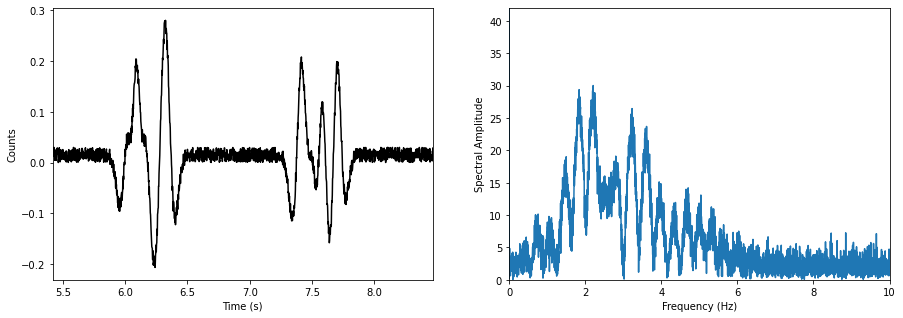

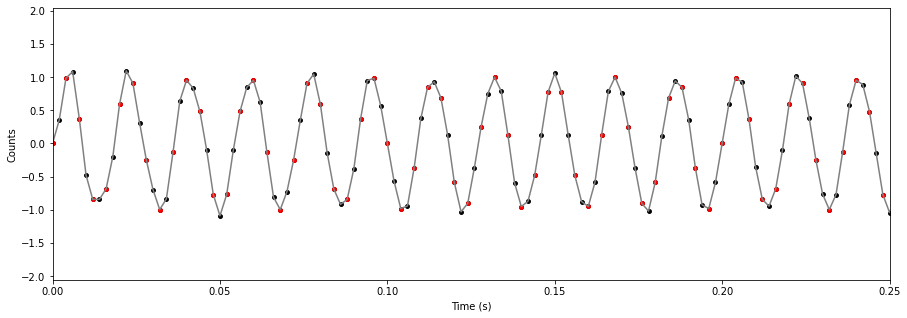

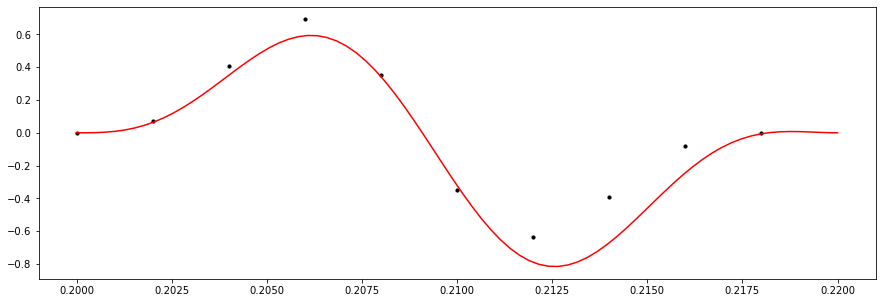

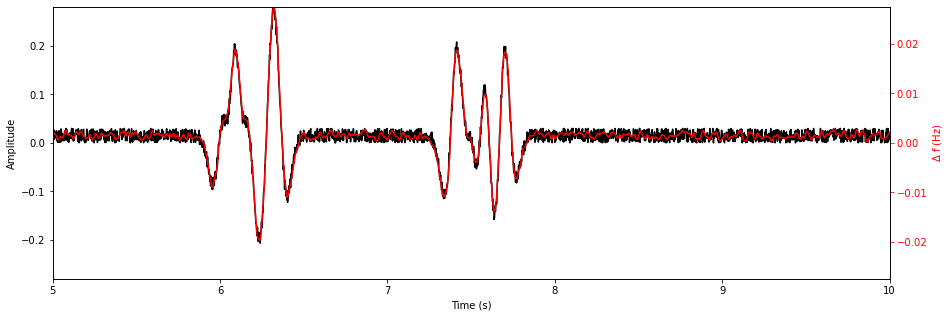

ValueError: operands could not be broadcast together with shapes (39991,) (80000,) 

In [12]:
## set sampling frequency for digital signal 
fs_digi = sps/2


## creating an event with center frequency fc
fc = 20 # Hz

tt_event, event = __create_event(T, sps, fc, True)

## sampling the synthetic analog signal to a digital time series
sig_dig = __analog_to_digital(sgnc, event, T, sps, fs_digi, 0.1)

## interpolate the digital time series
tt_res, sig_dig_res = __resample_digital_signal(sig_dig, fs_digi, 1, False)


# _____________________________________________________________________________________________________________
tt_demod, sig_demod = __sinus_fit(tt_res, sig_dig_res, 10, 2) ; option = 'option1'

# _____________________________________________________________________________________________________________
#tt_demod, sig_demod = __instantaneous_frequency_hilbert(sig_dig_res, tt_res, fs_digi) ; option = 'option2'

# _____________________________________________________________________________________________________________
#tt_demod, sig_demod = __hibert_filter(sig_dig_res,tt_res,fs_digi) ; option = 'option3'




## _________________________________________
## Plotting

__makeplot_comparison(tt_demod, sig_demod, tt_event, event, option, sps, sgnc)


# __makeplot_diff(tt_demod, sig_demod-event)


In [ ]:
shift = 200.0

#%time

def demod(y,sample_period,fc,mod_fac,shift,ym,ts):

    yc = y 

    theta_orig = 2 * np.pi * (fc + mod_fac * ym) * ts 
    theta_new  = np.arcsin(yc)


    # Calculate the samples per quadrant
    N = int(1 / fc / sample_period) 
    Nq = int(N / 4)

    # Solve the angles for Yc's 1st cycle
    quadrant1_theta = theta_new[0:Nq]
    quadrant2_theta = np.pi - theta_new[Nq:Nq*2]
    quadrant3_theta = np.pi - theta_new[Nq*2:Nq*3]
    quadrant4_theta = 2.0 * np.pi + theta_new[Nq*3:Nq*4]
    theta_corrected = np.hstack((quadrant1_theta, quadrant2_theta, quadrant3_theta, quadrant4_theta))

    number_of_cycles = fc * len(ts) 

    # This is our tally
    cycle = 1
    cycle_start_index = Nq*4
    pi_multiple=2

    while cycle < number_of_cycles:

        # Calculate which sample falls into what quadrant
        quad1_start = cycle_start_index
        quad1_end = quad1_start + Nq

        quad23_start = quad1_end
        quad23_end = quad23_start + Nq * 2

        quad4_start = quad23_end
        quad4_stop = quad4_start + Nq

        # Solve for the angles for Yc's 2nd, 3rd, ... cycles
        quadrant1_theta = theta_new[quad1_start:quad1_end] + pi_multiple * np.pi 
        quadrant23_theta = np.pi - theta_new[quad23_start:quad23_end] + pi_multiple * np.pi
        quadrant4_theta = 2.0 * np.pi + theta_new[quad4_start:quad4_stop] + pi_multiple * np.pi 

        theta_corrected = np.hstack((theta_corrected, quadrant1_theta, quadrant23_theta, quadrant4_theta))

        cycle = cycle + 1


        # Calculate a distinct offset for each cycle 
        pi_multiple = pi_multiple + 2.0

        cycle_start_index = cycle_start_index + N

    return (theta_corrected / (2.0 * np.pi * ts *  mod_fac) - fc / mod_fac ) 


sig_demod = demod(sig_dig_res,1/fs,sgnc,0.1,shift,event,tt_res) 

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.signal import hilbert, chirp

# duration = 1.0
# fs = 400.0
# samples = int(fs*duration)
# t = np.arange(samples) / fs

# signal = chirp(t, 20.0, t[-1], 100.0) 
# signal *= (1.0 + 0.5 * np.sin(2.0*np.pi*200*t) )

# #analytic_signal = hilbert(np.hanning(len(signal))*signal)
# analytic_signal = hilbert(signal)


# amplitude_envelope = np.abs(analytic_signal)
# instantaneous_phase = np.unwrap(np.angle(analytic_signal))
# instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs)


# fig = plt.figure()
# fig.subplots_adjust(hspace=0.7)

# ax0 = fig.add_subplot(411)
# ax0.plot(t, signal, label='signal')
# #ax0.plot(t, amplitude_envelope, label='envelope')
# ax0.set_xlabel("time in seconds")
# ax0.legend()
# ax1 = fig.add_subplot(412)
# ax1.plot(t[1:], instantaneous_frequency)
# ax1.set_xlabel("time in seconds")
# ax1.set_ylim(0.0, 120.0)

# ax2 = fig.add_subplot(413)
# ax2.plot(t,np.real(hilbert(signal)))

# ax3 = fig.add_subplot(414)
# ax3.plot(t,analytic_signal-signal,'black')

# plt.show();
